In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od

In [3]:
dataset = 'https://www.kaggle.com/datasets/datasnaek/youtube-new'

In [4]:
od.download(dataset)

Skipping, found downloaded files in ".\youtube-new" (use force=True to force download)


In [5]:
import os

In [6]:
data_dir = r'.\youtube-new'


In [7]:
os.listdir(data_dir)

['.ipynb_checkpoints',
 'CAvideos.csv',
 'CA_category_id.json',
 'DEvideos.csv',
 'DE_category_id.json',
 'FRvideos.csv',
 'FR_category_id.json',
 'GBvideos.csv',
 'GB_category_id.json',
 'INvideos.csv',
 'IN_category_id.json',
 'JPvideos.csv',
 'JP_category_id.json',
 'KRvideos.csv',
 'KR_category_id.json',
 'MXvideos.csv',
 'MX_category_id.json',
 'RUvideos.csv',
 'RU_category_id.json',
 'USvideos.csv',
 'US_category_id.json']

In [8]:
#🧹 Step 3: Data Preprocessing

In [28]:
import os

file_path = "./youtube-new/INvideos.csv"
print("Found!" if os.path.exists(file_path) else "Not found.")


Found!


In [34]:
import pandas as pd
import datetime

# Load the dataset
df = pd.read_csv("youtube-new\\INvideos.csv")  # double backslash


# Convert publish_time to datetime safely
df['publish_time'] = pd.to_datetime(df['publish_time'], errors='coerce')

# Drop rows where publish_time conversion failed
df.dropna(subset=['publish_time'], inplace=True)

# Extract date and hour
df['publish_date'] = df['publish_time'].dt.date
df['publish_hour'] = df['publish_time'].dt.hour

# Show info and summary
print(df.info())
print(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37352 entries, 0 to 37351
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   video_id                37352 non-null  object             
 1   trending_date           37352 non-null  object             
 2   title                   37352 non-null  object             
 3   channel_title           37352 non-null  object             
 4   category_id             37352 non-null  int64              
 5   publish_time            37352 non-null  datetime64[ns, UTC]
 6   tags                    37352 non-null  object             
 7   views                   37352 non-null  int64              
 8   likes                   37352 non-null  int64              
 9   dislikes                37352 non-null  int64              
 10  comment_count           37352 non-null  int64              
 11  thumbnail_link          37352 non-null  o

In [36]:
#Step 4:Exploratory Data Analysis (EDA)

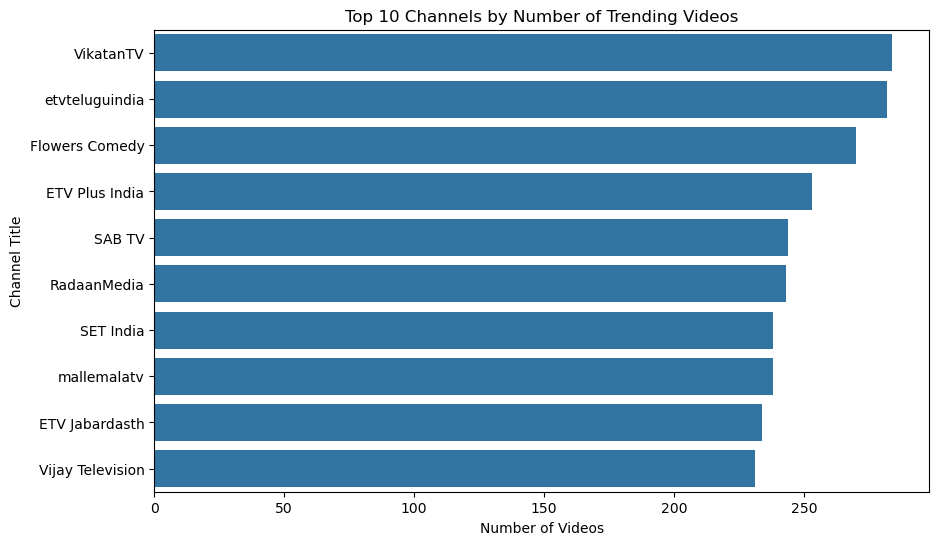

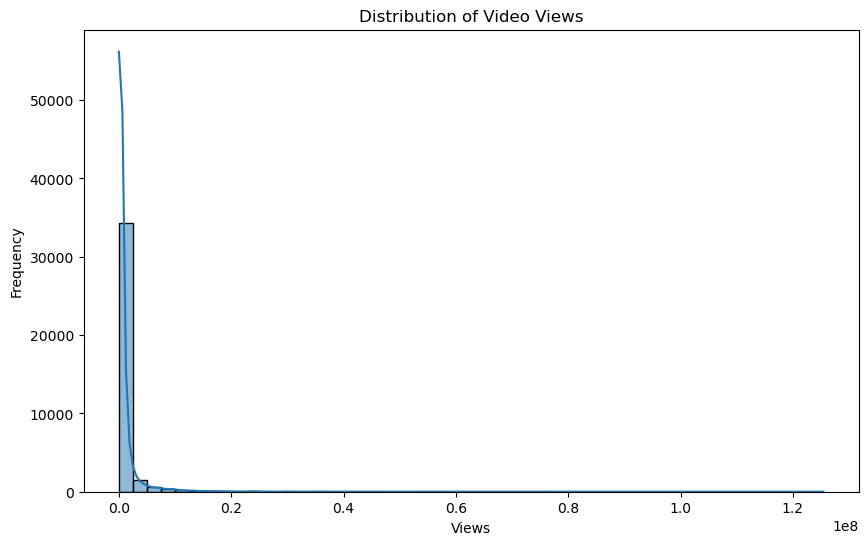

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Top 10 channels by number of trending videos
top_channels = df['channel_title'].value_counts().head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=top_channels.values, y=top_channels.index)
plt.title('Top 10 Channels by Number of Trending Videos')
plt.xlabel('Number of Videos')
plt.ylabel('Channel Title')
plt.show()

# Distribution of video views
plt.figure(figsize=(10,6))
sns.histplot(df['views'], bins=50, kde=True)
plt.title('Distribution of Video Views')
plt.xlabel('Views')
plt.ylabel('Frequency')
plt.show()



In [42]:
#Step 4:Sentiment Analysis (Optional)

In [44]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download VADER lexicon
nltk.download('vader_lexicon')

# Initialize SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Compute sentiment scores
df['title_sentiment'] = df['title'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Display sentiment scores
print(df[['title', 'title_sentiment']].head())



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\anubh\AppData\Roaming\nltk_data...


                                               title  title_sentiment
0  Sharry Mann: Cute Munda ( Song Teaser) | Parmi...           0.4588
1  पीरियड्स के समय, पेट पर पति करता ऐसा, देखकर दं...           0.0000
2  Stylish Star Allu Arjun @ ChaySam Wedding Rece...           0.0000
3                     Eruma Saani | Tamil vs English           0.0000
4  why Samantha became EMOTIONAL @ Samantha naga ...           0.3254


In [46]:
#Step 5: Time-Series Analysis

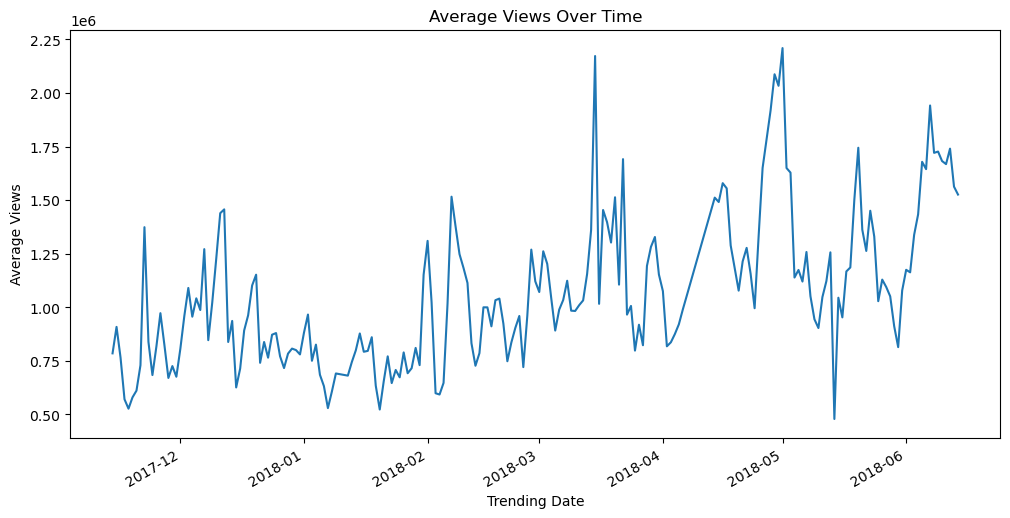

In [48]:
# Convert trending_date to datetime
df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m')

# Group by trending_date and compute average views
daily_views = df.groupby('trending_date')['views'].mean()

# Plot average views over time
plt.figure(figsize=(12,6))
daily_views.plot()
plt.title('Average Views Over Time')
plt.xlabel('Trending Date')
plt.ylabel('Average Views')
plt.show()




In [60]:
#step 6:Use SQLite to rank categories by avg views
import pandas as pd
import sqlite3
import json

# Load videos CSV
videos_df = pd.read_csv('youtube-new/INvideos.csv')

# Load category JSON to extract id-name mapping
with open('youtube-new/IN_category_id.json') as f:
    category_data = json.load(f)

# Extract category_id to category_name mapping
categories = {
    int(item['id']): item['snippet']['title']
    for item in category_data['items']
}

# Add category_name to DataFrame
videos_df['category_name'] = videos_df['category_id'].map(categories)


In [62]:
#2. Create SQLite Database and Insert Data
# Connect to SQLite
conn = sqlite3.connect('youtube.db')

# Save the DataFrame to SQLite
videos_df.to_sql('videos', conn, if_exists='replace', index=False)


37352

In [64]:
#Run SQL Query to Rank by Average Views
query = """
SELECT 
    category_name,
    AVG(views) AS avg_views,
    RANK() OVER (ORDER BY AVG(views) DESC) AS rank
FROM 
    videos
GROUP BY 
    category_name
ORDER BY 
    avg_views DESC;
"""

result = pd.read_sql_query(query, conn)
print(result)


           category_name     avg_views  rank
0                 Gaming  4.162462e+06     1
1                 Movies  3.065001e+06     2
2                  Music  2.631116e+06     3
3       Film & Animation  2.320356e+06     4
4                 Sports  1.887755e+06     5
5         Pets & Animals  1.626581e+06     6
6          Entertainment  9.645997e+05     7
7          Howto & Style  8.725960e+05     8
8   Science & Technology  8.643316e+05     9
9                 Comedy  8.421324e+05    10
10                 Shows  6.808873e+05    11
11        People & Blogs  5.198568e+05    12
12      Autos & Vehicles  4.220101e+05    13
13       News & Politics  3.805121e+05    14
14       Travel & Events  1.717928e+05    15
15             Education  1.186094e+05    16
16                  None  6.300149e+04    17


In [52]:
#Step 7: Topic Modeling with Gensim (Optional)

In [72]:
import gensim
from gensim import corpora
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

# Download stopwords
nltk.download('stopwords')
nltk.download('punkt_tab')




[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anubh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\anubh\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

In [74]:
# Preprocess titles
stop_words = set(stopwords.words('english'))
df['tokens'] = df['title'].apply(lambda x: [word for word in word_tokenize(x.lower()) if word.isalpha() and word not in stop_words])

# Create dictionary and corpus
dictionary = corpora.Dictionary(df['tokens'])
corpus = [dictionary.doc2bow(text) for text in df['tokens']]

# Build LDA model
lda_model = gensim.models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=10)

# Print topics
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx}: {topic}")

Topic 0: 0.016*"video" + 0.010*"kapoor" + 0.010*"sharma" + 0.010*"ep" + 0.009*"show" + 0.008*"vs" + 0.008*"official" + 0.008*"singh" + 0.007*"kaala" + 0.006*"rajinikanth"
Topic 1: 0.034*"song" + 0.029*"june" + 0.029*"video" + 0.028*"full" + 0.021*"songs" + 0.018*"latest" + 0.016*"official" + 0.016*"punjabi" + 0.014*"new" + 0.013*"movie"
Topic 2: 0.040*"episode" + 0.030*"may" + 0.027*"telugu" + 0.020*"etv" + 0.017*"promo" + 0.017*"full" + 0.017*"trailer" + 0.016*"april" + 0.016*"tv" + 0.016*"tamil"
Topic 3: 0.023*"episode" + 0.022*"comedy" + 0.012*"sri" + 0.012*"reddy" + 0.012*"may" + 0.011*"current" + 0.011*"affairs" + 0.011*"zhala" + 0.011*"kalyan" + 0.010*"series"
Topic 4: 0.031*"episode" + 0.019*"news" + 0.018*"best" + 0.017*"scene" + 0.017*"march" + 0.014*"ki" + 0.013*"ka" + 0.009*"marathi" + 0.009*"mehta" + 0.009*"taarak"


In [76]:
df.to_csv('processed_youtube_data.csv', index=False)

In [ ]:
 # Most popular genres, sentiments

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\anubh\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


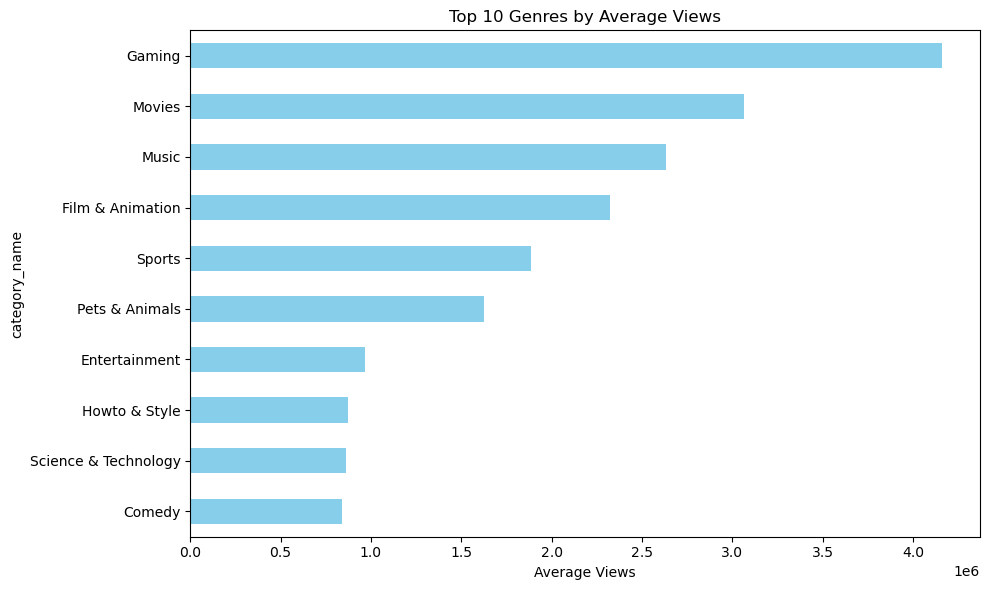

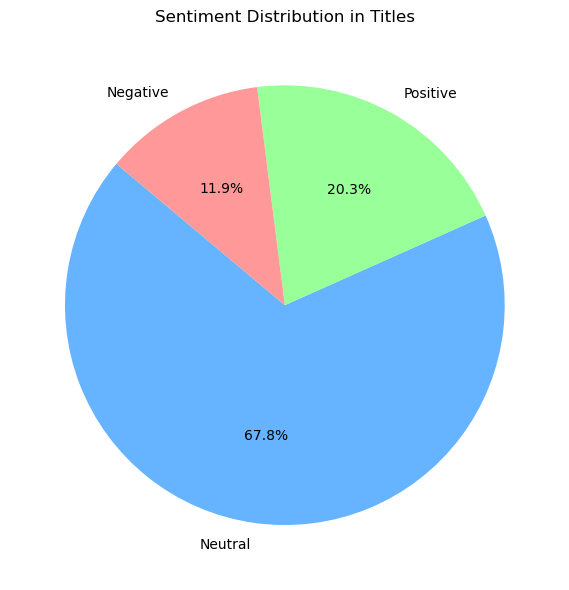

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Load Data
df = pd.read_csv("./youtube-new/INvideos.csv")
with open("./youtube-new/IN_category_id.json", "r") as f:
    category_data = json.load(f)
categories = {int(item['id']): item['snippet']['title'] for item in category_data['items']}
df['category_name'] = df['category_id'].map(categories)

# Sentiment Analysis
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
df['sentiment_score'] = df['title'].astype(str).apply(lambda x: sia.polarity_scores(x)['compound'])
df['sentiment'] = df['sentiment_score'].apply(lambda x: 'Positive' if x >= 0.05 else ('Negative' if x <= -0.05 else 'Neutral'))

# Visuals
plt.figure(figsize=(10, 6))
df.groupby('category_name')['views'].mean().sort_values(ascending=False).head(10).plot(kind='barh', color='skyblue')
plt.title("Top 10 Genres by Average Views")
plt.xlabel("Average Views")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("top_genres.png")

plt.figure(figsize=(6, 6))
df['sentiment'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=['#66b3ff','#99ff99','#ff9999'])
plt.title("Sentiment Distribution in Titles")
plt.ylabel("")
plt.tight_layout()
plt.savefig("sentiment_distribution.png")

In [9]:
#Region-wise comparison visuals

In [11]:
# step 1: Combine Multiple Regional Datasets

In [17]:
# Load multiple regions
regions = ['IN', 'US', 'GB']
dfs = []

for region in regions:
    df_region = pd.read_csv(f"./youtube-new/{region}videos.csv")
    df_region['region'] = region
    dfs.append(df_region)

# Combine all into one dataframe
df = pd.concat(dfs, ignore_index=True)

# Load category names (assuming they are the same for all)
with open("./youtube-new/IN_category_id.json", "r") as f:
    category_data = json.load(f)
categories = {int(item['id']): item['snippet']['title'] for item in category_data['items']}
df['category_name'] = df['category_id'].map(categories)

In [19]:
#Step 2: Sentiment Analysis

In [21]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
df['sentiment_score'] = df['title'].astype(str).apply(lambda x: sia.polarity_scores(x)['compound'])
df['sentiment'] = df['sentiment_score'].apply(lambda x: 'Positive' if x >= 0.05 else ('Negative' if x <= -0.05 else 'Neutral'))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\anubh\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [23]:
#Step 3: Region-wise Comparsion Visuals

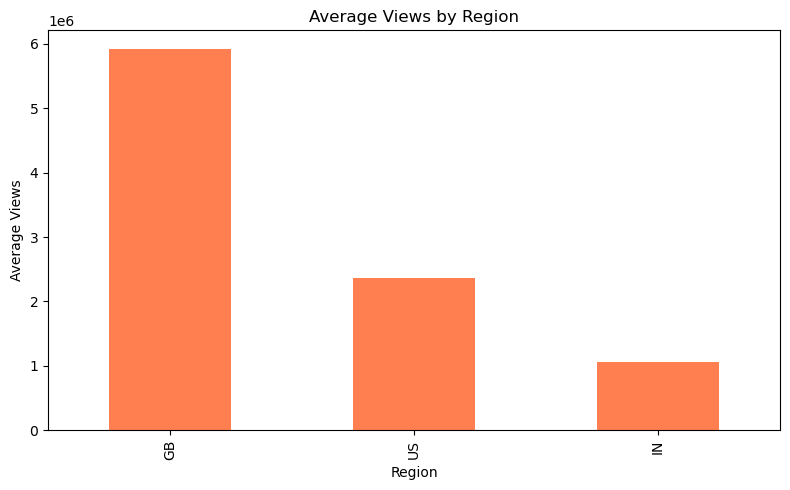

In [25]:
#1.Average Views by Region
plt.figure(figsize=(8, 5))
df.groupby('region')['views'].mean().sort_values(ascending=False).plot(kind='bar', color='coral')
plt.title("Average Views by Region")
plt.xlabel("Region")
plt.ylabel("Average Views")
plt.tight_layout()
plt.savefig("avg_views_by_region.png")

In [27]:
#2.Sentiment Distribution by Region

<Figure size 1000x600 with 0 Axes>

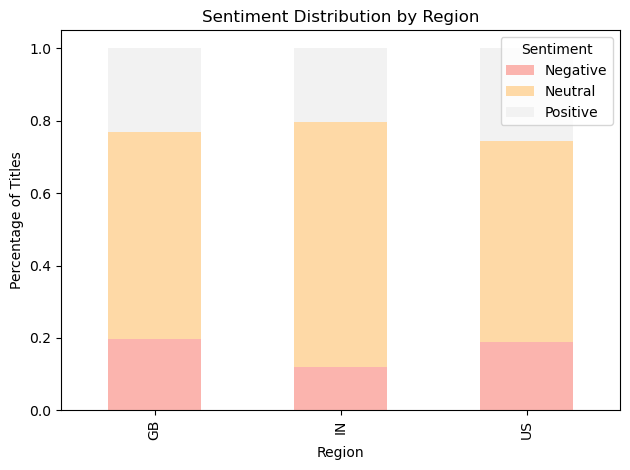

In [29]:
plt.figure(figsize=(10, 6))
region_sentiment = df.groupby(['region', 'sentiment']).size().unstack().fillna(0)
region_sentiment_pct = region_sentiment.div(region_sentiment.sum(axis=1), axis=0)
region_sentiment_pct.plot(kind='bar', stacked=True, colormap='Pastel1')
plt.title("Sentiment Distribution by Region")
plt.xlabel("Region")
plt.ylabel("Percentage of Titles")
plt.legend(title='Sentiment')
plt.tight_layout()
plt.savefig("sentiment_by_region.png")

In [ ]:
#3.Heatmap: Average Views by Region & Category
plt.figure(figsize=(14, 8))
heat_data = df.pivot_table(index='region', columns='category_name', values='views', aggfunc='mean').fillna(0)
sns.heatmap(heat_data, cmap='YlGnBu', linewidths=0.5)
plt.title("Average Views by Region and Category")
plt.xlabel("Category")
plt.ylabel("Region")
plt.tight_layout()
plt.savefig("region_category_heatmap.png")